In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

In [2]:
def plot_to_map(size, longitude, latitude) :
    stamen_terrain = cimgt.StamenTerrain()
    
    plt.figure(figsize = size)
    ax = plt.axes(projection = ccrs.Mercator())
    
    min_long = longitude.min() - 0.5
    max_long = longitude.max() + 0.5
    min_lat = latitude.min() - 0.5
    max_lat = latitude.max() + 0.5
    ax.set_extent([min_long, max_long, min_lat, max_lat])
    
    #ax.add_image(stamen_terrain, 8)
    ax.add_feature(cfeat.LAND.with_scale('50m'))
    ax.add_feature(cfeat.OCEAN.with_scale('50m'))
    ax.add_feature(cfeat.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeat.BORDERS.with_scale('50m'))
    ax.add_feature(cfeat.RIVERS.with_scale('50m'))
    
    ax.scatter(x = longitude, y = latitude, transform = ccrs.PlateCarree())
    
    # Draw Rotterdam marker
    ax.scatter(x = 4.47917, y = 51.9225, transform = ccrs.PlateCarree(), marker = '*', c = 'C1', s = 500)
    # Draw Felixstowe marker
    ax.scatter(x = 1.351255, y = 51.961726, transform = ccrs.PlateCarree(), marker = '*', c = 'C1', s = 500)
    
    return

In [3]:
def plot_routes_to_map(ais_data) :
    plt.figure(figsize = (13, 13))
    ax = plt.axes(projection = ccrs.Mercator())
    
    min_long = ais_data['Longitude'].min() - 0.5
    max_long = ais_data['Longitude'].max() + 0.5
    min_lat = ais_data['Latitude'].min() - 0.5
    max_lat = ais_data['Latitude'].max() + 0.5
    ax.set_extent([min_long, max_long, min_lat, max_lat])
    
    ax.add_feature(cfeat.LAND.with_scale('50m'))
    ax.add_feature(cfeat.OCEAN.with_scale('50m'))
    ax.add_feature(cfeat.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeat.BORDERS.with_scale('50m'))
    ax.add_feature(cfeat.RIVERS.with_scale('50m'))
    
    ais_data.plot(x = 'Longitude', y = 'Latitude', C = 'TravelTime')
    
    # Draw Rotterdam marker
    ax.scatter(x = 4.47917, y = 51.9225, transform = ccrs.PlateCarree(), marker = '*', c = 'C1', s = 500)
    # Draw Hamburg marker
    ax.scatter(x = 10.01534, y = 53.57532, transform = ccrs.PlateCarree(), marker = '*', c = 'C1', s = 500)

In [4]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
ais = pd.read_csv('felixstowe_rotterdam.arff', names = names, skiprows = 27, parse_dates = True, index_col = 'ID',
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [5]:
ais.head()

,TripID,MMSI,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,...,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Name,Callsign,AisSourcen
ID,,,,,,,,,,,,,,,,,,,,,
39542658,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.31,1.2,264.0,297.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
39543951,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.31,2.3,285.0,293.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
39545048,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.30,4.6,280.0,262.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
39545774,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.30,3.7,251.0,218.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001
39547226,40903,220284000,51.95,1.31,'2016-1-21 08:46',51.9,4.36,'2016-1-21 17:17',FELIXSTOWE,ROTTERDAM,...,6.68,51.95,1.30,3.8,210.0,180.0,RTM-FXT-RTM,SUECIA.SEAWAYS,OVPB2,H7001


In [6]:
# Convert time columns to correct dtype
ais['StartTime'] = pd.to_datetime(ais['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais['EndTime'] = pd.to_datetime(ais['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais['time'] = pd.to_datetime(ais['time'], format = '\'%Y-%m-%d %H:%M\'')

In [7]:
# Convert all headings that are 511 (>= 360) to NaN
ais.loc[ais['TH'] >= 360, 'TH'] = np.nan

In [8]:
# Convert courses >= 360 to NaN
ais.loc[ais['COG'] >= 360, 'COG'] = np.nan

In [9]:
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais.loc[(ais['shiptype'] == '0') | (ais['shiptype'] == '159'), 'shiptype'] = np.nan

In [10]:
# Set invalid lengths (0 or > 400) to NaN
ais.loc[(ais['Length'] <= 0) | (ais['Length'] > 400), 'Length'] = np.nan

In [11]:
# Set speeds that are unrealisticly high to NaN
ais.loc[ais['SOG'] > 25.6, 'SOG'] = np.nan

In [12]:
ais = ais.drop(['AisSourcen', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)

In [13]:
ais.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Callsign
ID,,,,,,,,,,,,,,,,,,
39542658,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 17:17:00,2016-01-21 08:47:00,196.0,26,6.68,51.95,1.31,1.2,264.0,297.0,RTM-FXT-RTM,OVPB2
39543951,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 17:17:00,2016-01-21 08:48:00,196.0,26,6.68,51.95,1.31,2.3,285.0,293.0,RTM-FXT-RTM,OVPB2
39545048,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 17:17:00,2016-01-21 08:49:00,196.0,26,6.68,51.95,1.30,4.6,280.0,262.0,RTM-FXT-RTM,OVPB2
39545774,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 17:17:00,2016-01-21 08:50:00,196.0,26,6.68,51.95,1.30,3.7,251.0,218.0,RTM-FXT-RTM,OVPB2
39547226,40903,51.95,1.31,2016-01-21 08:46:00,51.9,4.36,2016-01-21 17:17:00,2016-01-21 08:51:00,196.0,26,6.68,51.95,1.30,3.8,210.0,180.0,RTM-FXT-RTM,OVPB2


Text(0.5,1,u'All Positions Before Filtering')

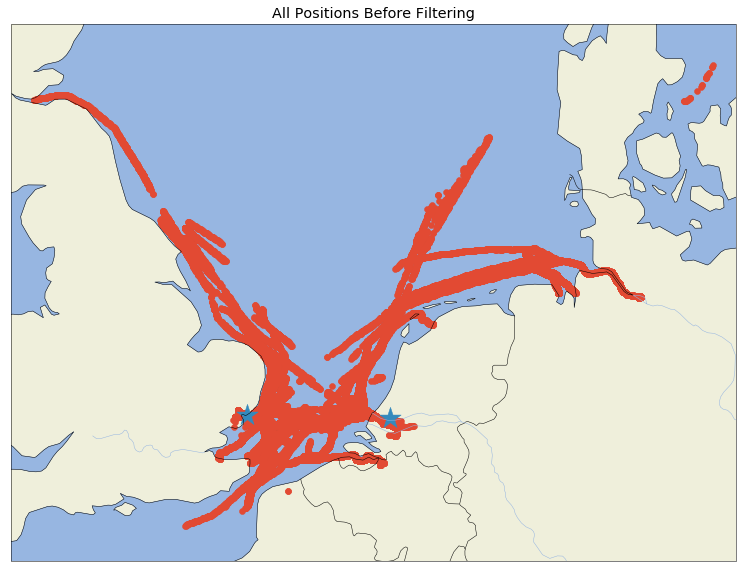

In [14]:
# Plot all positions in the data before any filters are applied
plot_to_map(size = (13, 13), longitude = ais['Longitude'], latitude = ais['Latitude'])
plt.title("All Positions Before Filtering")

Text(0.5,1,u'Start Positions Before Filtering')

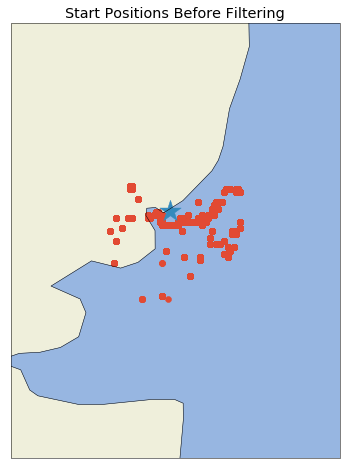

In [15]:
# Plot start positions before any filtering to map
plot_to_map(size = (8, 8), longitude = ais['StartLongitude'], latitude = ais['StartLatitude'])
plt.title("Start Positions Before Filtering")

Text(0.5,1,u'End Positions Before Filtering')

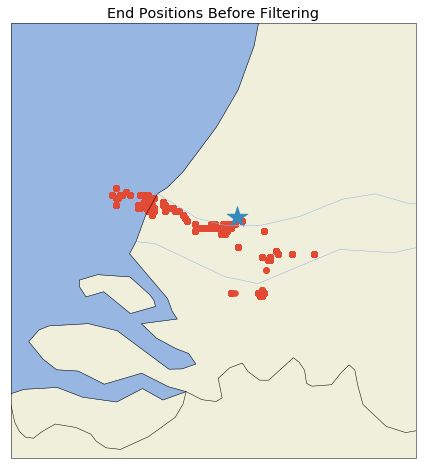

In [16]:
# Plot end positions before any filtering to map
plot_to_map(size = (8, 8), longitude = ais['EndLongitude'], latitude = ais['EndLatitude'])
plt.title("End Positions Before Filtering")

In [ ]:
# Get rid of trips that leave our zone (2.45 - 10.66 / 51.49 - 55.06)

outside_long_mask = (ais['Longitude'] < 2.45) | (ais['Longitude'] > 10.66)
outside_lat_mask = (ais['Latitude'] < 51.49) | (ais['Latitude'] > 55.06)

outside_rec_mask = outside_long_mask | outside_lat_mask

outside_trip_ids = ais['TripID'][outside_rec_mask].unique()
outside_trip_mask = ~ais['TripID'].isin(outside_trip_ids)
ais = ais[outside_trip_mask]

In [ ]:
plot_to_map(size = (13, 13), longitude = ais['Longitude'], latitude = ais['Latitude'])
plt.title("All Positions After Filtering to Our Zone")

In [17]:
# Add time for the entire trip to the data
ais['TravelTime'] = ais['EndTime'] - ais['StartTime']

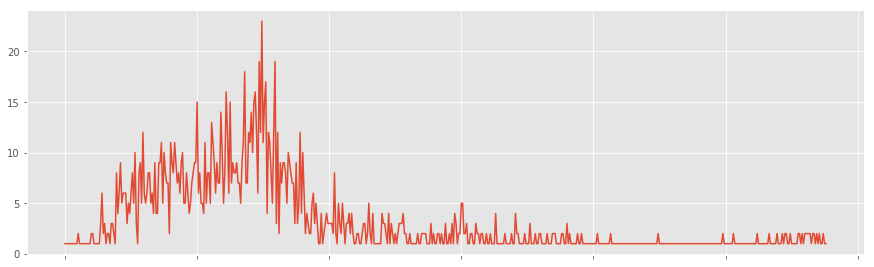

In [49]:
ais.groupby('TripID')['TravelTime'].max().value_counts().sort_index().plot(figsize = (15, 5))

In [ ]:
# Add time remaining until arrival at destination
ais['remainingTT'] = ais['EndTime'] - ais['time']

In [ ]:
# Get and plot the longest trip in the data set
longest_trip = ais[ais['TravelTime'] == ais['TravelTime'].max()]
longest_trip.head()

In [ ]:
plot_to_map(size = (13, 13), longitude = longest_trip['Longitude'], latitude = longest_trip['Latitude'])
plt.title("Longest Trip in the Data Set")

In [ ]:
# Holidaymaker from our Weka filtering plottet
holidaymaker = ais[ais['TripID'] == '834747']
plot_to_map(size = (13, 13), longitude = holidaymaker['Longitude'], latitude = holidaymaker['Latitude'])

In [ ]:
ursulas_trips = ais[ais['Callsign'] == '3FDB8']
ursulas_shortest = ursulas_trips[ursulas_trips['TravelTime'] == ursulas_trips['TravelTime'].min()]
plot_to_map(size = (13, 13), longitude = ursulas_shortest['Longitude'], latitude = ursulas_shortest['Latitude'])
plt.title("Ursula's Shortest Trip")

In [ ]:
ais['TravelTime'].describe()

In [ ]:
plt.figure(figsize = (15, 5))
ais['TravelTime'].value_counts().plot()

In [ ]:
short_trip_mask = ais['TravelTime'] < pd.Timedelta('1 days 9 h')
ais[short_trip_mask]['TravelTime'].describe()
#ais = ais[short_trip_mask]
#ais['TravelTime'].describe()

In [ ]:
plt.figure(figsize = (15, 5))
plot_routes_to_map(ais_data = ais[short_trip_mask])

In [ ]:
ais['TripID'].describe()

In [ ]:
ais.groupby('TripID').max()['Callsign'].describe()

In [ ]:
ais['SOG'].describe()